In [221]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [222]:
#Импортируем спаршенные данные
df = pd.read_excel(r"aktsii.xlsx")
df

,TICKER,ЦЕНА,КОЛИЧЕСТВО АКЦИЙ,ПРИБЫЛЬ,ВЫРУЧКА,FCF,Собственный капитал (EQUITY),АКТИВЫ 2021,АКТИВЫ 2022,ROA,Балансовая стоиомтсь,Размер,Чистые активы,CEO's gender,CEO's age,CEO's education,CEO's qual
0,CIAN,595.20,69042400,480000000,8266000000,1802000000,5009000000,5600000000,6974000000,0.076348,5009000000,0.199181,5009000000,1,1,0,1
1,ETLN,79.98,383441416,13001000000,80556000000,-52016000000,74189000000,222098000000,248045000000,0.055307,74189000000,0.078900,74189000000,0,1,1,0
2,FIXP,295.50,850000000,21411000000,277644000000,24767000000,29267000000,84929000000,113026000000,0.216322,29267000000,0.073923,29267000000,0,1,0,1
3,GLTR,615.40,178740916,24919886000,94474032000,28752204000,67462195000,108284996000,110154102000,0.228163,67462195000,0.154419,67462195000,1,0,1,0
4,HHRU,2973.00,50635720,3691494000,18085164000,7219260000,6863685000,22782272000,23900880000,0.158151,6863685000,0.073514,6863685000,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,MAGE,4.45,145673254,-2561000000,11923000000,-2966000000,3484000000,14070000000,18478000000,-0.157368,3484000000,0.053521,3484000000,1,0,0,0
108,SAGO,3.15,3538928532,1122014000,40754572000,1227829000,6380626000,9205918000,10285896000,0.115127,6380626000,0.163675,6380626000,1,0,0,0
109,SAGO,3.15,521993080,1122014000,40754572000,1227829000,6380626000,9205918000,10285896000,0.115127,6380626000,0.163675,6380626000,0,1,0,1
110,SLEN,4.96,1237175444,-6295000000,12475000000,-3245000000,11461000000,38654000000,28941000000,-0.186256,11461000000,0.084777,11461000000,0,0,0,0


In [223]:
df_for_analyze = df[["CEO's gender", "ПРИБЫЛЬ", "ВЫРУЧКА", "FCF"]].replace([0,1], ["Male", "Female"])
df_for_analyze_mean = df_for_analyze.groupby(["CEO's gender"]).mean()/1000000
df_for_analyze_mean.round(2)
df_for_analyze_mean["ТИП"] = "Mean"

df_for_analyze_median = df_for_analyze.groupby(["CEO's gender"]).median()/1000000
df_for_analyze_median.round(2)
df_for_analyze_median["ТИП"] = "Median"

pd.concat([df_for_analyze_mean, df_for_analyze_median])


,ПРИБЫЛЬ,ВЫРУЧКА,FCF,ТИП
CEO's gender,,,,
Female,9314.754636,72471.978945,4938.054909,Mean
Male,48975.204737,459723.067193,32143.804825,Mean
Female,1833.000000,18085.164000,1009.687000,Median
Male,1740.240000,51502.000000,299.979000,Median


<Axes: xlabel='FCF', ylabel='Count'>

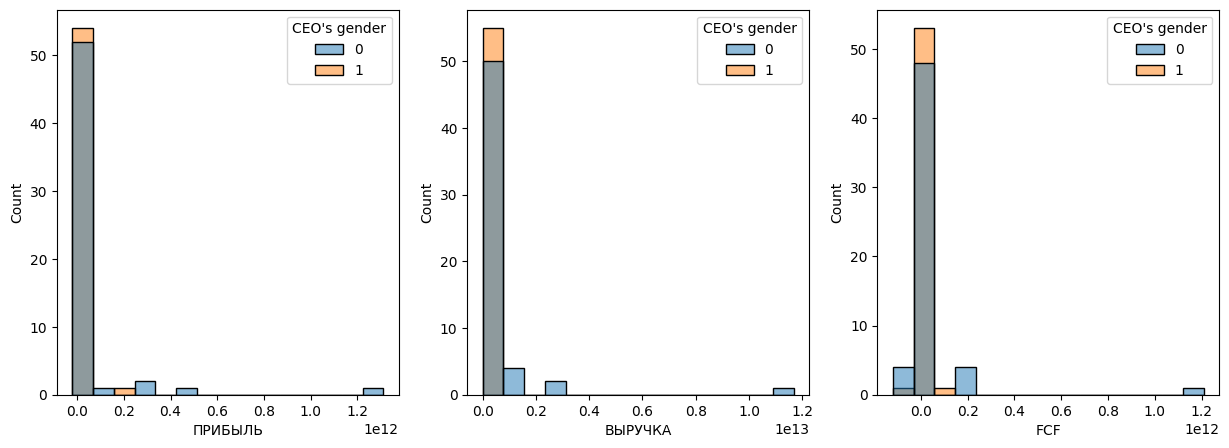

In [224]:
f, axes = plt.subplots(1, 3, figsize=(15, 5))


sns.histplot(df, x = "ПРИБЫЛЬ", bins=15, hue= """CEO's gender""", ax=axes[0])
sns.histplot(df, x = "ВЫРУЧКА", bins=15, hue= """CEO's gender""",  ax=axes[1])
sns.histplot(df, x = "FCF", bins=15, hue= """CEO's gender""", ax=axes[2])

c:\Users\izarkhin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\izarkhin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='FCF_log', ylabel='Count'>

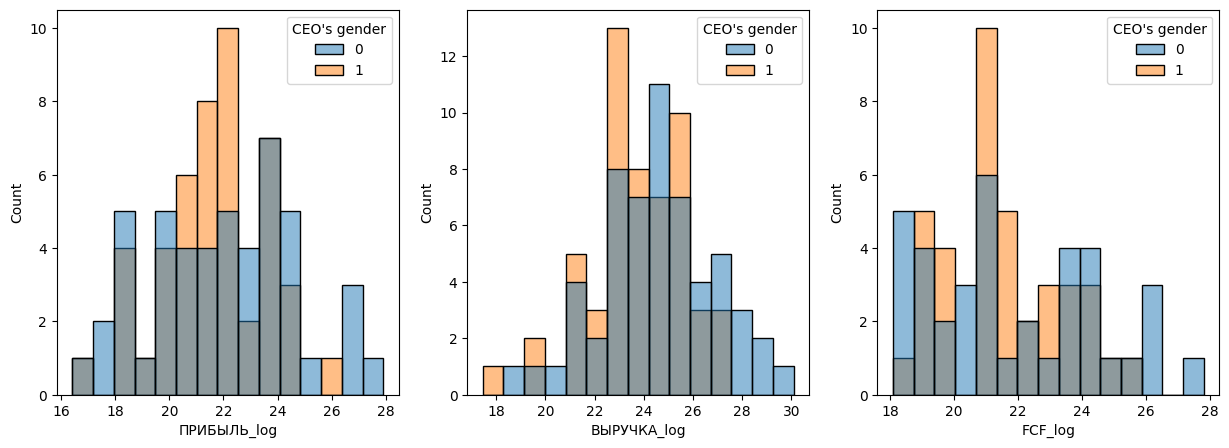

In [225]:
df["ПРИБЫЛЬ_log"] = np.log(df["ПРИБЫЛЬ"])
df["ВЫРУЧКА_log"] = np.log(df["ВЫРУЧКА"])
df["FCF_log"] = np.log(df["FCF"])

f, axes = plt.subplots(1, 3, figsize=(15, 5))


sns.histplot(df, x = "ПРИБЫЛЬ_log", bins=15, hue= """CEO's gender""", ax=axes[0])
sns.histplot(df, x = "ВЫРУЧКА_log", bins=15, hue= """CEO's gender""",  ax=axes[1])
sns.histplot(df, x = "FCF_log", bins=15, hue= """CEO's gender""", ax=axes[2])

,CEO's gender,ПРИБЫЛЬ_log,ВЫРУЧКА_log,FCF_log,ROA
CEO's gender,1.000000,-0.063418,-0.196218,-0.082541,0.036448
ПРИБЫЛЬ_log,-0.063418,1.000000,0.853334,0.862168,0.265592
ВЫРУЧКА_log,-0.196218,0.853334,1.000000,0.786606,0.166791
FCF_log,-0.082541,0.862168,0.786606,1.000000,0.323662
ROA,0.036448,0.265592,0.166791,0.323662,1.000000


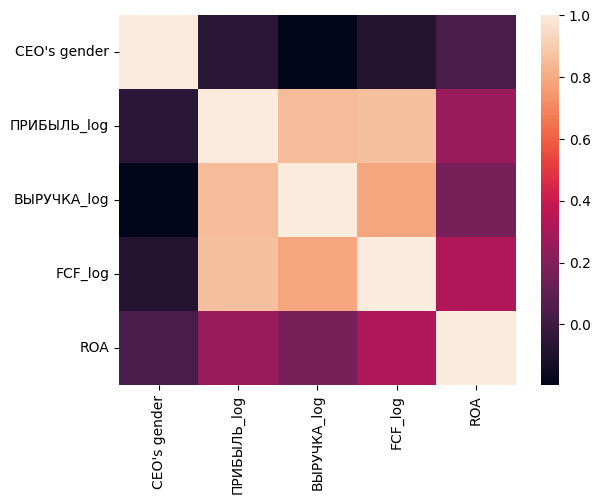

In [226]:
df_for_corralation = df[["CEO\'s gender", "ПРИБЫЛЬ_log", "ВЫРУЧКА_log", "FCF_log", "ROA"]]
sns.heatmap(df_for_corralation.corr())
df_for_corralation.corr()

In [227]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy

In [228]:
#Модель

dfForOls = df.dropna()
y = dfForOls["ROA"]
x = dfForOls[dfForOls.columns.difference(['ROA', "TICKER"])]
x = sm.add_constant(x)

results = sm.OLS(y, x).fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROA   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     4.071
Date:                Tue, 26 Dec 2023   Prob (F-statistic):           5.17e-05
Time:                        12:08:30   Log-Likelihood:                 79.113
No. Observations:                  71   AIC:                            -124.2
Df Residuals:                      54   BIC:                            -85.76
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.2033      0.192      1.057      0.295      -0.183       0.589
CEO's age                       -0.0308      0.025     -1.237      0.221      -0.081       0.019
CEO's education                  0.0291      0.025      1.180      0.243      -0.020       0.079
CEO's gender                     0.0044      0.025      0.178      0.859      -0.045       0.054
CEO's qual                      -0.0097      0.024     -0.408      0.685      -0.057       0.038
FCF                           1.246e-12   5.15e-13      2.418      0.019    2.13e-13    2.28e-12
FCF_log                         -0.0081      0.020     -0.415      0.680      -0.047       0.031
АКТИВЫ 2021                    1.29e-12    5.9e-13      2.187      0.033    1.07e-13    2.47e-12
АКТИВЫ 2022                  -1.473e-12   6.25e-13     -2.356      0.022   -2.73e-12    -2.2e-13
Балансовая стоиомтсь             0.0004      0.000      2.413      0.019    7.55e-05       0.001
ВЫРУЧКА                        2.85e-14   3.89e-14      0.733      0.467   -4.95e-14    1.06e-13
ВЫРУЧКА_log                     -0.0520      0.013     -3.925      0.000      -0.079      -0.025
КОЛИЧЕСТВО АКЦИЙ             -3.613e-14   4.82e-14     -0.750      0.457   -1.33e-13    6.05e-14
ПРИБЫЛЬ                       3.441e-13   3.32e-13      1.038      0.304   -3.21e-13    1.01e-12
ПРИБЫЛЬ_log                      0.0663      0.017      3.844      0.000       0.032       0.101
Размер                          -0.6296      0.261     -2.413      0.019      -1.153      -0.106
Собственный капитал (EQUITY)    -0.0005      0.000     -1.870      0.067      -0.001    3.88e-05
ЦЕНА                           3.47e-06   6.49e-06      0.535      0.595   -9.54e-06    1.65e-05
Чистые активы                  9.15e-05      0.000      0.610      0.544      -0.000       0.000
==============================================================================
Omnibus:                       70.381   Durbin-Watson:                   1.763
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              626.449
Skew:                           2.826   Prob(JB):                    9.30e-137
Kurtosis:                      16.410   Cond. No.                     1.05e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+17. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [229]:
# ### Проверка на ошибку первого рода

#МНК оценка модели без свободного члена
y = dfForOls["ROA"]
x = dfForOls[dfForOls.columns.difference(['ROA', "TICKER"])]

res = sm.OLS(y,x).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    ROA   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     4.259
Date:                Tue, 26 Dec 2023   Prob (F-statistic):           3.72e-05
Time:                        12:08:30   Log-Likelihood:                 78.386
No. Observations:                  71   AIC:                            -124.8
Df Residuals:                      55   BIC:                            -88.57
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
CEO's age       

In [230]:
params = res.params
x = x
y = y

i=0
for param in params:
    residuals = y-x[x.columns[i]]*param
    y=residuals



dfForOls["Остатки"] = residuals

dfForOls



    


C:\Users\izarkhin\AppData\Local\Temp\ipykernel_10392\1357339602.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfForOls["Остатки"] = residuals


,TICKER,ЦЕНА,КОЛИЧЕСТВО АКЦИЙ,ПРИБЫЛЬ,ВЫРУЧКА,FCF,Собственный капитал (EQUITY),АКТИВЫ 2021,АКТИВЫ 2022,ROA,...,Размер,Чистые активы,CEO's gender,CEO's age,CEO's education,CEO's qual,ПРИБЫЛЬ_log,ВЫРУЧКА_log,FCF_log,Остатки
0,CIAN,595.20,69042400,480000000,8266000000,1802000000,5009000000,5600000000,6974000000,0.076348,...,0.199181,5009000000,1,1,0,1,19.989297,22.835417,21.312163,0.654119
2,FIXP,295.50,850000000,21411000000,277644000000,24767000000,29267000000,84929000000,113026000000,0.216322,...,0.073923,29267000000,0,1,0,1,23.787171,26.349606,23.932778,0.794093
3,GLTR,615.40,178740916,24919886000,94474032000,28752204000,67462195000,108284996000,110154102000,0.228163,...,0.154419,67462195000,1,0,1,0,23.938932,25.271591,24.081980,0.228163
4,HHRU,2973.00,50635720,3691494000,18085164000,7219260000,6863685000,22782272000,23900880000,0.158151,...,0.073514,6863685000,1,1,1,1,22.029297,23.618358,22.700018,0.735922
5,MDMG,786.00,75125010,4718800000,25222056000,6564718000,26963262000,34282277000,33162389000,0.139931,...,0.199892,26963262000,0,1,1,0,22.274820,23.950985,22.604975,0.717702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,YAKG,96.75,826919375,1833000000,7580000000,1957000000,14128000000,27192000000,29195000000,0.065015,...,0.125277,14128000000,1,0,0,1,21.329220,22.748779,21.394679,0.065015
101,DIOD,15.97,91500000,42330000,561241000,97647000,1200092000,1412937000,1417146000,0.029914,...,0.212024,1200092000,0,1,1,1,17.561007,20.145661,18.396869,0.607685
102,NAUK,540.50,11789500,104155000,2322220000,246977000,2571875000,5944633000,6741145000,0.016421,...,0.101368,2571875000,0,0,0,1,18.461391,21.565789,19.324806,0.016421
108,SAGO,3.15,3538928532,1122014000,40754572000,1227829000,6380626000,9205918000,10285896000,0.115127,...,0.163675,6380626000,1,0,0,0,20.838391,24.430834,20.928513,0.115127


In [231]:
#Проверка коэффициентов в двух выборках
y1 = dfForOls["ROA"][1:55]
x1 = dfForOls[dfForOls.columns.difference(['ROA', "TICKER"])][1:55]

y2 = dfForOls["ROA"][55:]
x2 = dfForOls[dfForOls.columns.difference(['ROA', "TICKER"])][55:]

res1 = sm.OLS(y1,x1).fit().params
res2 = sm.OLS(y2,x2).fit().params
pd.concat([res1, res2], axis = 1).rename(columns = {0: "Коэффициент первой половины", 1: "Коэффициенты второй половины"})

,Коэффициент первой половины,Коэффициенты второй половины
CEO's age,-5.777710e-01,-4.706149e-02
CEO's education,-5.454228e-10,-3.420952e-02
CEO's gender,1.881180e-10,-3.424235e-02
CEO's qual,1.487699e-10,-4.451970e-04
FCF,-4.021862e-18,1.499246e-10
FCF_log,2.089185e-10,-3.093841e-02
АКТИВЫ 2021,2.535496e-18,-7.751037e-11
АКТИВЫ 2022,-4.462088e-18,6.380277e-11
Балансовая стоиомтсь,1.468032e-05,-1.080732e-05
ВЫРУЧКА,1.053621e-18,-1.059720e-12


In [232]:
#Статистика Бреуша-Годфри
sm.stats.diagnostic.acorr_breusch_godfrey (res, nlags = 1)

(2.481646527291988,
 0.11518161674816085,
 0.8108661792420424,
 0.37193788611980727)

In [233]:
# ## Проверка предпосылок Гаусса-Маркова 

# In[1474]:


#F-test

#Контролирующая выборка
y_control1 = dfForOls["ROA"][0:1]
x_control1 = dfForOls[dfForOls.columns.difference(['ROA', "TICKER"])][0:1]

y_control2 = dfForOls["ROA"][1:2]
x_control2 = dfForOls[dfForOls.columns.difference(['ROA', "TICKER"])][1:2]

y_control3 = dfForOls["ROA"][2:3]
x_control3 = dfForOls[dfForOls.columns.difference(['ROA', "TICKER"])][2:3]

y_control4 = dfForOls["ROA"][3:4]
x_control4 = dfForOls[dfForOls.columns.difference(['ROA', "TICKER"])][3:4]

y_control5 = dfForOls["ROA"][4:5]
x_control5 = dfForOls[dfForOls.columns.difference(['ROA', "TICKER"])][4:5]


#Обучающая выборка
y_study = dfForOls["ROA"][5:]
x_study = dfForOls[dfForOls.columns.difference(['ROA', "TICKER"])][5:]
res_final = sm.OLS(y_study,x_study).fit()
res_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROA   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.921e+07
Date:                Tue, 26 Dec 2023   Prob (F-statistic):          8.62e-161
Time:                        12:08:30   Log-Likelihood:                 562.64
No. Observations:                  66   AIC:                            -1091.
Df Residuals:                      49   BIC:                            -1054.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
CEO's age                       -0.5778   4.88e-05  -1.19e+04      0.000      -0.578      -0.578
CEO's education               5.552e-10   1.61e-05   3.45e-05      1.000   -3.24e-05    3.24e-05
CEO's gender                  2.463e-09   1.59e-05      0.000      1.000   -3.19e-05    3.19e-05
CEO's qual                    6.375e-09   1.55e-05      0.000      1.000   -3.11e-05    3.11e-05
FCF                          -2.581e-18   3.37e-16     -0.008      0.994   -6.79e-16    6.74e-16
FCF_log                      -6.648e-09   1.23e-05     -0.001      1.000   -2.47e-05    2.47e-05
АКТИВЫ 2021                  -5.486e-18   3.76e-16     -0.015      0.988   -7.61e-16     7.5e-16
АКТИВЫ 2022                  -4.869e-18   4.03e-16     -0.012      0.990   -8.14e-16    8.04e-16
Балансовая стоиомтсь         -8.459e-05   3.31e-08  -2555.672      0.000   -8.47e-05   -8.45e-05
ВЫРУЧКА                      -4.056e-18   2.24e-17     -0.181      0.857    -4.9e-17    4.09e-17
ВЫРУЧКА_log                   1.303e-09   7.79e-06      0.000      1.000   -1.56e-05    1.56e-05
КОЛИЧЕСТВО АКЦИЙ             -1.765e-18   2.98e-17     -0.059      0.953   -6.16e-17    5.81e-17
Остатки                          1.0000    8.4e-05   1.19e+04      0.000       1.000       1.000
ПРИБЫЛЬ                      -7.425e-18   2.05e-16     -0.036      0.971   -4.19e-16    4.04e-16
ПРИБЫЛЬ_log                    4.95e-09    1.2e-05      0.000      1.000    -2.4e-05     2.4e-05
Размер                        6.892e-08      0.000      0.000      1.000      -0.000       0.000
Собственный капитал (EQUITY) -8.009e-05   1.55e-08  -5180.882      0.000   -8.01e-05   -8.01e-05
ЦЕНА                          4.769e-13   4.01e-09      0.000      1.000   -8.06e-09    8.06e-09
Чистые активы                    0.0002   4.82e-08   3414.642      0.000       0.000       0.000
==============================================================================
Omnibus:                      137.954   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8721.923
Skew:                           7.337   Prob(JB):                         0.00
Kurtosis:                      57.372   Cond. No.                     7.75e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.75e+16. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [234]:
#Тест Готфрида-Квандта
gq = sm.stats.diagnostic.het_goldfeldquandt(y_study, x_study, drop=0.2)
print("p-value gq равно", gq[1])

p-value gq равно 0.9999999999999999


In [236]:
#Вычисление стандартного отклонения случайных остатков
statistics_test = pd.concat([y_study,x_study], axis = 1)
#statistics_test["Остатки"] = statistics_test["ВРП"] - (res.params[0]*statistics_test["Затраты на инновации"]+res.params[1]*statistics_test["Инвестиции"]+                                            res.params[2]*statistics_test["Затраты на труд"])

params = res.params
x = x_study
y = y_study

i=0
for param in params:
    residuals = y-x[x.columns[i]]*param
    y=residuals

statistics_test["Остатки"] = residuals


##
statistics_test["Остатки в квадрате"] = statistics_test["Остатки"]**2
sigma = (sum(statistics_test["Остатки в квадрате"])/57)**0.5

print("Стандартное отклонение случайных остатков равно ", sigma)

Стандартное отклонение случайных остатков равно  0.4972277849740454


In [239]:
# # Проверка на адекватность


#Определяем t-критическое
t_crit = scipy.stats.t.ppf(1-0.05/2, 60)
t_crit


# In[1478]:


#Значения y для сравнения
pd.concat([y_control1, y_control2, y_control3, y_control4, y_control5])


0    0.076348
2    0.216322
3    0.228163
4    0.158151
5    0.139931
Name: ROA, dtype: float64